In [ ]:
!pip install transformers torch torchvision Pillow numpy matplotlib scikit-learn requests

In [ ]:
# --- Python Code (Run this entire block in a new Colab cell AFTER installations) ---
import torch
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity # Just in case, though direct tensor multiplication is used
import os # For checking local file existence if needed

# --- 1. Configuration & Model Loading ---
# Automatically detect if a GPU is available and use it
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print("Loading CLIP model and processor...")
# We're using a base CLIP variant (openai/clip-vit-base-patch32).
# It's a good balance of performance and size (~300MB download).
# Other options: openai/clip-vit-large-patch14 is more powerful but larger (~600MB).
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name).to(device) # Load model to GPU/CPU
clip_processor = CLIPProcessor.from_pretrained(model_name) # Load processor (tokenizer + image preprocessor)
print("CLIP model loaded.")

# --- 2. Define Core Zero-Shot Detection Function ---

def zero_shot_image_detector(image_input, verbose=True):
    """
    Performs zero-shot image detection based on semantic similarity to predefined text prompts.

    Args:
        image_input: Can be a PIL Image object, a local file path, or a URL.
        verbose (bool): If True, prints detailed explanations and shows plots.

    Returns:
        dict: A dictionary containing prediction, confidence scores, and explanation data.
              Returns None if image loading fails.
    """
    if verbose:
        print("\n--- Starting Zero-Shot Detection ---")

    # --- Image Loading ---
    image = None
    if isinstance(image_input, str):
        if image_input.startswith(('http://', 'https://')):
            try:
                # Use a timeout for URL requests to prevent hangs
                image = Image.open(requests.get(image_input, stream=True, timeout=10).raw).convert("RGB")
            except requests.exceptions.RequestException as e:
                print(f"Error requesting image from URL: {image_input}. Error: {e}")
                return None # Indicate failure
            except Image.UnidentifiedImageError:
                print(f"Error: Could not identify image from URL: {image_input}. It might not be a valid image file.")
                return None
            except Exception as e:
                print(f"Unexpected error loading image from URL: {image_input}. Error: {e}")
                return None
        else: # Assume local file path
            if not os.path.exists(image_input):
                 print(f"Error: Local image file not found at {image_input}")
                 return None
            try:
                image = Image.open(image_input).convert("RGB")
            except Exception as e:
                print(f"Error loading local image file: {image_input}. Error: {e}")
                return None
    elif isinstance(image_input, Image.Image):
        image = image_input.convert("RGB")
    else:
        print("Error: Invalid image_input type. Must be PIL Image, local path, or URL.")
        return None

    if image is None: # If image loading failed
        return {"prediction": "Error", "confidence": 0.0, "explanation": "Image loading failed."}


    # --- Define your descriptive text prompts for detection categories ---
    # These are crucial for zero-shot capability. Customize them for specific nuances!
    text_prompts = [
        # General Reality vs. AI categories
        "a real photograph",
        "an authentic picture",
        "an unaltered photo",
        "a genuine image",

        "an AI-generated image",
        "a synthetic image",
        "a fabricated image",
        "a fake image",

        # Image Style / Origin categories
        "a hand-drawn illustration",
        "a painting",
        "a sketch",
        "a cartoon character",
        "a computer-generated artwork",
        "a Ghibli-style illustration",
        "an anime drawing",
        "a photorealistic rendering", # Can sometimes capture AI trying to be real

        # Specific AI Model Styles (if known, for fine-grained detection)
        "a DALL-E generated image",
        "a Midjourney artwork",
        "a Stable Diffusion creation",

        # Specific Deepfake / Manipulation related terms (CLIP might pick up on subtle artifacts)
        "a deepfaked image",
        "an altered image",
        "a manipulated photo",
        "a deepfaked human face",

        # Content types (for contextual understanding if needed for logic refinement)
        "a human face",
        "an animal",
        "an object",
        "a landscape",
        "a text overlay", # For images with text on them
    ]

    # --- Preprocess image and texts for CLIP model ---
    # `padding=True` ensures all text prompts are padded to the same length
    inputs = clip_processor(text=text_prompts, images=image, return_tensors="pt", padding=True).to(device)

    # --- Get image and text features (embeddings) from CLIP ---
    # `torch.no_grad()` saves memory and speeds up inference
    with torch.no_grad():
        image_features = clip_model.get_image_features(pixel_values=inputs.pixel_values)
        text_features = clip_model.get_text_features(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask)

    # --- Normalize features for accurate cosine similarity calculation ---
    # Normalization is essential before computing cosine similarity
    image_features_norm = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
    text_features_norm = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

    # --- Calculate cosine similarity between the image and all text prompts ---
    # The result is a tensor (1, num_prompts), squeezed to (num_prompts,)
    similarities = (image_features_norm @ text_features_norm.T).squeeze(0)

    # Convert similarities to percentages for easier interpretation
    similarities_percent = (similarities * 100).cpu().numpy()

    # --- Zero-Shot Detection Logic ---
    # Sort prompts by similarity for insights and display
    sorted_indices = np.argsort(similarities_percent)[::-1] # Get indices of sorted scores (descending)
    sorted_prompts = [text_prompts[i] for i in sorted_indices]
    sorted_scores = [similarities_percent[i] for i in sorted_indices]

    # Helper to safely get similarity for a prompt (handles case if prompt not in list)
    def get_sim(prompt_text):
        try: return similarities_percent[text_prompts.index(prompt_text)]
        except ValueError: return -100.0 # Return a very low score if prompt not found


    # Define key scores for primary detection averages
    real_prompts = ["a real photograph", "an authentic picture", "an unaltered photo", "a genuine image"]
    ai_prompts = ["an AI-generated image", "a synthetic image", "a fabricated image", "a fake image"]
    deepfake_prompts = ["a deepfaked image", "a manipulated photo", "a deepfaked human face", "an altered image"]

    # Calculate average similarities for core categories, ignoring prompts not found
    avg_real_sim = np.mean([get_sim(p) for p in real_prompts if get_sim(p) > -99.0]) if real_prompts else -100.0
    avg_ai_sim = np.mean([get_sim(p) for p in ai_prompts if get_sim(p) > -99.0]) if ai_prompts else -100.0
    avg_deepfake_sim = np.mean([get_sim(p) for p in deepfake_prompts if get_sim(p) > -99.0]) if deepfake_prompts else -100.0

    prediction_label = "Unclear/Ambiguous"
    confidence_score = 0.0
    detailed_explanation = ""

    # --- Primary Decision Logic ---
    # A threshold to differentiate more clearly
    CONFIDENCE_THRESHOLD = 8.0 # Difference in percentage points for a confident call

    if avg_ai_sim > avg_real_sim + CONFIDENCE_THRESHOLD:
        prediction_label = "Likely AI-generated"
        confidence_score = avg_ai_sim - avg_real_sim
        detailed_explanation = "The image's features are significantly more aligned with descriptions of general AI-generated content than with real photographs."
    elif avg_real_sim > avg_ai_sim + CONFIDENCE_THRESHOLD:
        prediction_label = "Likely Real"
        confidence_score = avg_real_sim - avg_ai_sim
        detailed_explanation = "The image's features are significantly more aligned with descriptions of real and authentic photographs than with AI-generated content."
    else:
        # If real/AI are too close or low, default to unclear but refine with top match
        confidence_score = abs(avg_ai_sim - avg_real_sim)
        prediction_label = "Unclear/Ambiguous" # Default
        detailed_explanation = "The model found similar or ambiguous alignment between real and AI-generated content descriptions."
        if sorted_scores[0] > 60: # If there's a very strong top match, use it
             prediction_label = f"Best match: {sorted_prompts[0]} ({sorted_scores[0]:.2f}%)"
             detailed_explanation = f"While AI vs Real was ambiguous, the image strongly matches '{sorted_prompts[0]}'."


    # --- Refinement for Specific AI Styles / Deepfakes (if primary is AI or unclear) ---
    if "AI-generated" in prediction_label or "Unclear" in prediction_label:
        # Check for specific AI styles
        ai_style_prompts_list = [
            "a computer-generated artwork", "a Ghibli-style illustration",
            "an anime drawing", "a DALL-E generated image", "a Midjourney artwork",
            "a Stable Diffusion creation", "a photorealistic rendering"
        ]
        ai_style_scores_dict = {p: get_sim(p) for p in ai_style_prompts_list if get_sim(p) > -99.0}

        if ai_style_scores_dict:
            top_ai_style_prompt = max(ai_style_scores_dict, key=ai_style_scores_dict.get)
            top_ai_style_score = ai_style_scores_dict[top_ai_style_prompt]

            # If a specific AI style is very prominent and also beats "real" category
            if top_ai_style_score > avg_real_sim + CONFIDENCE_THRESHOLD + 5: # Higher threshold for specific style
                prediction_label = f"Likely AI-generated ({top_ai_style_prompt.replace('a ', '').replace('an ', '')})"
                detailed_explanation += f"\nIt exhibits particularly high similarity ({top_ai_style_score:.2f}%) to '{top_ai_style_prompt}'."

        # Check for deepfake/manipulation signals if they're strong
        if avg_deepfake_sim > avg_real_sim + CONFIDENCE_THRESHOLD:
            if prediction_label == "Likely Real" or "Unclear" in prediction_label: # Only override if not already strong AI
                 prediction_label = "Likely Manipulated/Deepfaked"
                 detailed_explanation += f"\nIt shows significant alignment ({avg_deepfake_sim:.2f}%) with descriptions of manipulated/deepfaked images."


    # --- Final Output Construction ---
    final_output = {
        "prediction": prediction_label,
        "confidence": confidence_score,
        "raw_similarities": dict(zip(text_prompts, similarities_percent)),
        "top_matches": list(zip(sorted_prompts[:5], sorted_scores[:5])), # Show top 5 overall matches
        "explanation": detailed_explanation,
        "image": image # Include the loaded image in the output for later display
    }

    if verbose:
        print(f"\nOverall Prediction: {final_output['prediction']}")
        print(f"Confidence (Difference Score): {final_output['confidence']:.2f}%")
        print("\nTop 5 Most Similar Prompts (Overall):")
        for prompt, score in final_output['top_matches']:
            print(f"- {prompt}: {score:.2f}%")
        print(f"\nExplanation: {final_output['explanation']}")

        # Plotting the top similarities for visualization
        fig, ax = plt.subplots(figsize=(10, 6))
        y_pos = np.arange(len(sorted_prompts[:10]))
        ax.barh(y_pos, sorted_scores[:10], align='center', color='skyblue')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(sorted_prompts[:10])
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Similarity (%)')
        ax.set_title(f'Image Similarity to Text Prompts (Top 10) - Predicted: {final_output["prediction"]}')
        plt.tight_layout()
        plt.show()

        # Display the input image
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis('off')
        plt.show()

    return final_output

Using device: cuda
Loading CLIP model and processor...
CLIP model loaded.



DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)

--- Demo 1: Real Human Photo) ---

--- Starting Zero-Shot Detection ---

Overall Prediction: Unclear/Ambiguous
Confidence (Difference Score): 2.52%

Top 5 Most Similar Prompts (Overall):
- a human face: 23.29%
- a synthetic image: 22.82%
- a photorealistic rendering: 22.75%
- an AI-generated image: 22.17%
- a manipulated photo: 22.12%

Explanation: The model found similar or ambiguous alignment between real and AI-generated content descriptions.


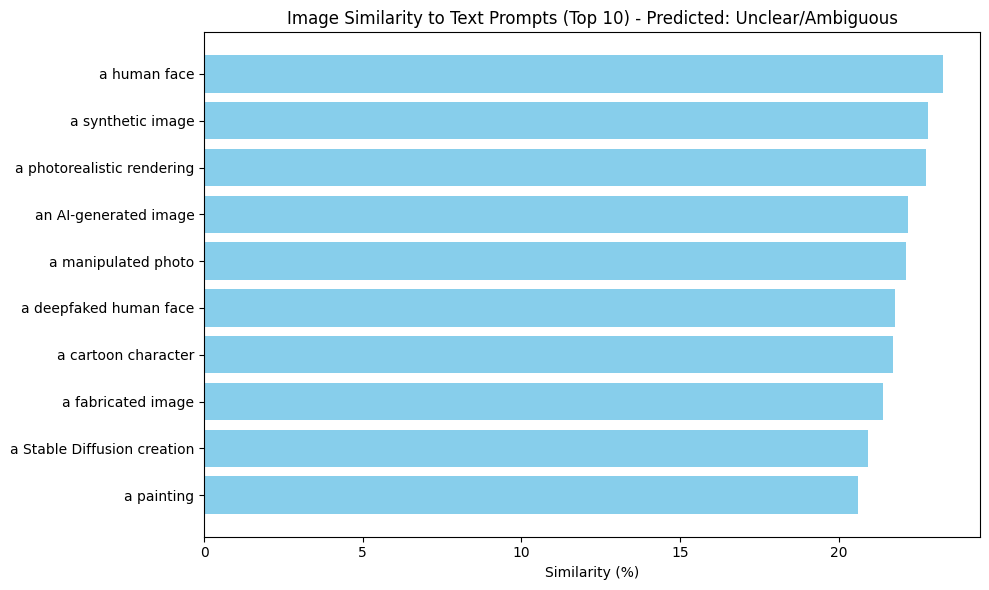

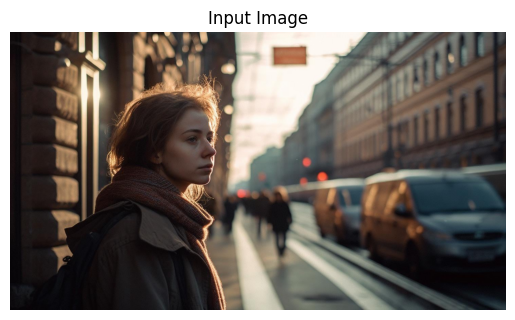

In [ ]:
# --- 3. Demo Usage ---
print("\n" + "="*60)
print("DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)")
print("="*60)

# Example 1: A Real Photograph (expected: Likely Real)
print("\n--- Demo 1: Real Human Photo) ---")
real_human_photo_url = "/content/10023.jpg" # Example human face
result1 = zero_shot_image_detector(real_human_photo_url)



DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)

--- Demo 1: Real Human Photo) ---

--- Starting Zero-Shot Detection ---

Overall Prediction: Unclear/Ambiguous
Confidence (Difference Score): 0.07%

Top 5 Most Similar Prompts (Overall):
- a cartoon character: 23.92%
- a fake image: 23.72%
- an AI-generated image: 23.44%
- a photorealistic rendering: 23.36%
- a deepfaked image: 23.28%

Explanation: The model found similar or ambiguous alignment between real and AI-generated content descriptions.


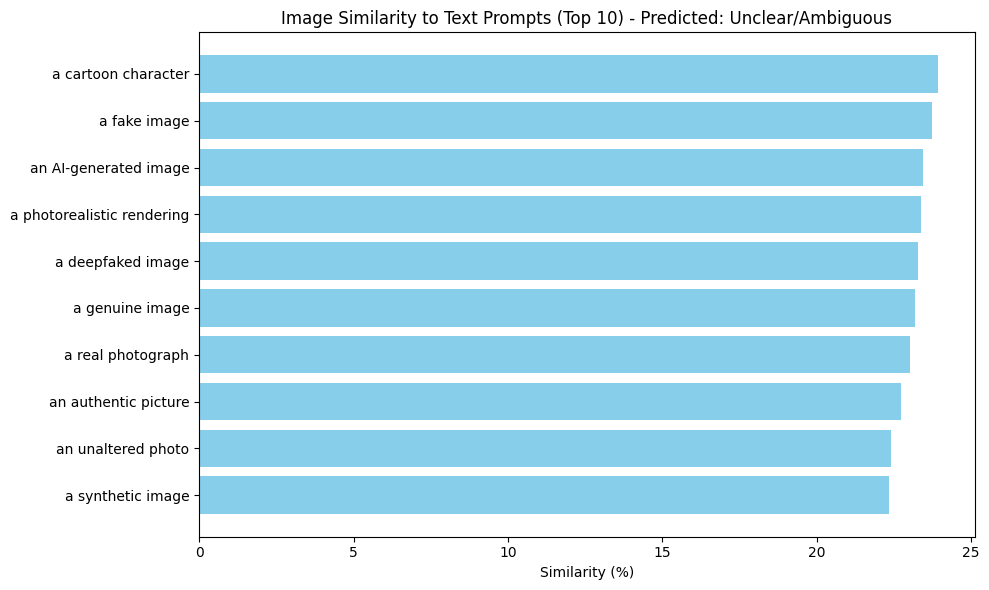

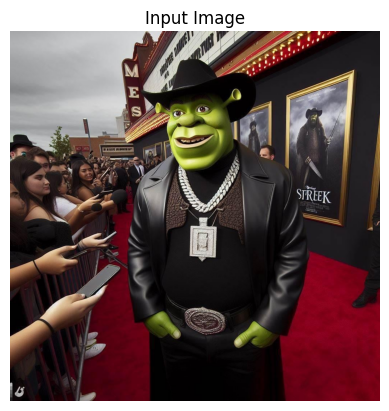

In [ ]:
print("DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)")
print("="*60)

# Example 1: A Real Photograph (expected: Likely Real)
print("\n--- Demo 1: Real Human Photo) ---")
real_human_photo_url = "/content/10.jpg" # Example human face
result1 = zero_shot_image_detector(real_human_photo_url)

DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)

--- Demo 1: Real Human Photo) ---

--- Starting Zero-Shot Detection ---

Overall Prediction: Unclear/Ambiguous
Confidence (Difference Score): 2.41%

Top 5 Most Similar Prompts (Overall):
- a Midjourney artwork: 26.73%
- a painting: 24.55%
- a computer-generated artwork: 24.33%
- a synthetic image: 24.29%
- a Ghibli-style illustration: 24.15%

Explanation: The model found similar or ambiguous alignment between real and AI-generated content descriptions.


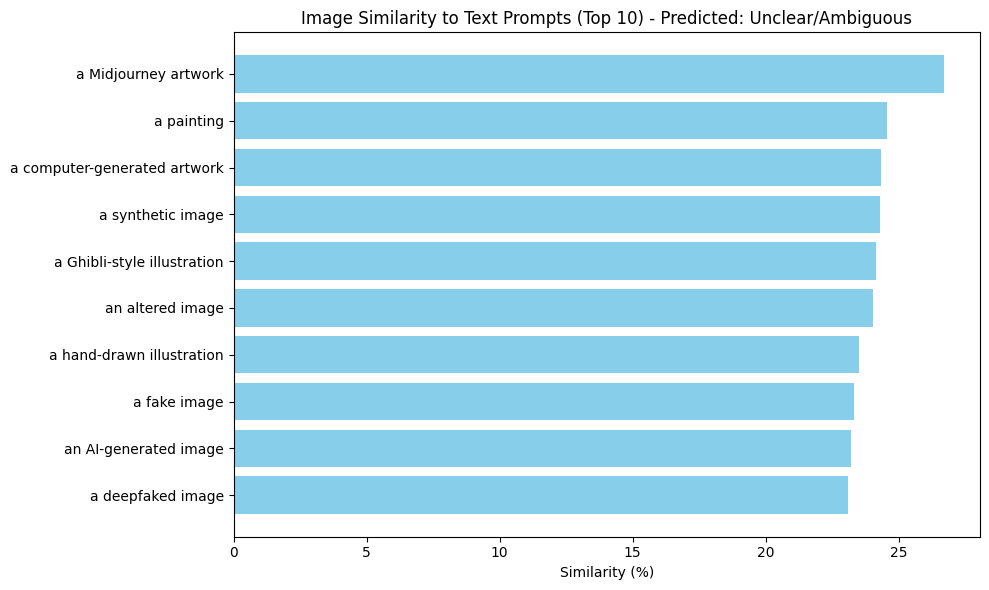

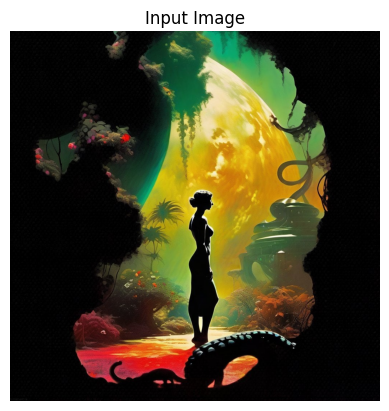

In [ ]:
print("DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)")
print("="*60)

# Example 1: A Real Photograph (expected: Likely Real)
print("\n--- Demo 1: Real Human Photo) ---")
real_human_photo_url = "/content/10000.jpg" # Example human face
result1 = zero_shot_image_detector(real_human_photo_url)

DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)

--- Demo 1: Real Human Photo) ---

--- Starting Zero-Shot Detection ---

Overall Prediction: Unclear/Ambiguous
Confidence (Difference Score): 2.52%

Top 5 Most Similar Prompts (Overall):
- a human face: 23.29%
- a synthetic image: 22.82%
- a photorealistic rendering: 22.75%
- an AI-generated image: 22.17%
- a manipulated photo: 22.12%

Explanation: The model found similar or ambiguous alignment between real and AI-generated content descriptions.


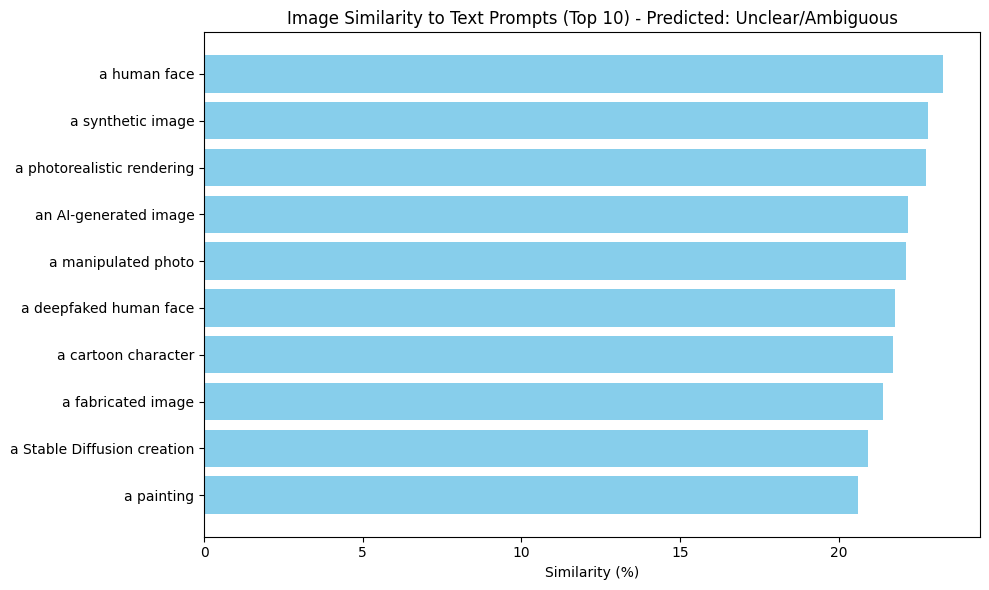

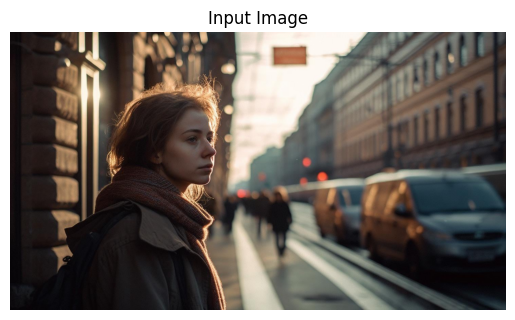

In [ ]:
print("DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)")
print("="*60)

# Example 1: A Real Photograph (expected: Likely Real)
print("\n--- Demo 1: Real Human Photo) ---")
real_human_photo_url = "/content/10023.jpg" # Example human face
result1 = zero_shot_image_detector(real_human_photo_url)

DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)

--- Demo 1: Real Human Photo) ---

--- Starting Zero-Shot Detection ---

Overall Prediction: Unclear/Ambiguous
Confidence (Difference Score): 1.04%

Top 5 Most Similar Prompts (Overall):
- a human face: 25.69%
- a deepfaked human face: 25.61%
- a photorealistic rendering: 24.18%
- a cartoon character: 23.40%
- a synthetic image: 22.52%

Explanation: The model found similar or ambiguous alignment between real and AI-generated content descriptions.


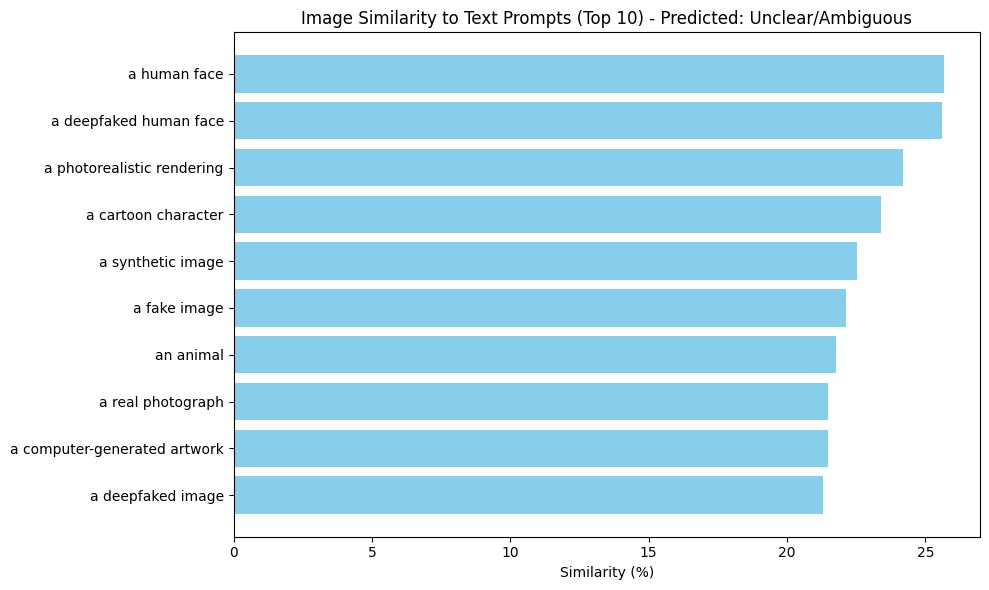

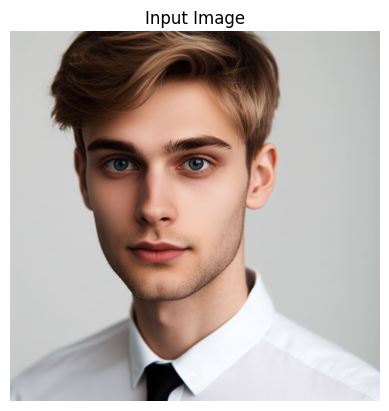

In [ ]:
print("DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)")
print("="*60)

# Example 1: A Real Photograph (expected: Likely Real)
print("\n--- Demo 1: Real Human Photo) ---")
real_human_photo_url = "/content/10c35d44-cba4-4509-8afa-a4bdc93a2afa.jpg" # Example human face
result1 = zero_shot_image_detector(real_human_photo_url)

DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)

--- Demo 1: Real Human Photo) ---

--- Starting Zero-Shot Detection ---

Overall Prediction: Unclear/Ambiguous
Confidence (Difference Score): 0.94%

Top 5 Most Similar Prompts (Overall):
- a landscape: 23.36%
- a photorealistic rendering: 23.00%
- an AI-generated image: 22.61%
- a fake image: 22.30%
- an unaltered photo: 22.28%

Explanation: The model found similar or ambiguous alignment between real and AI-generated content descriptions.


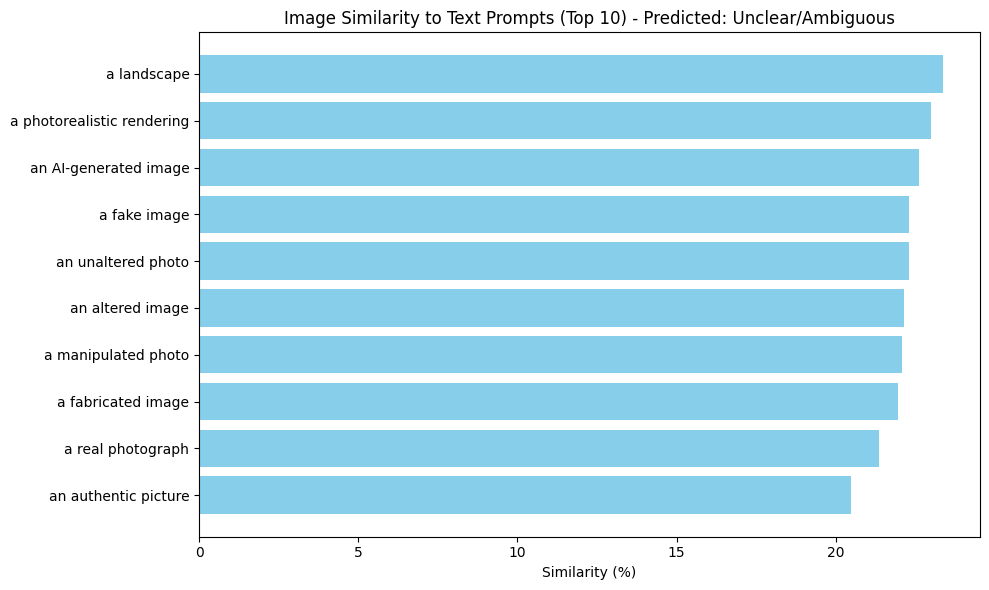

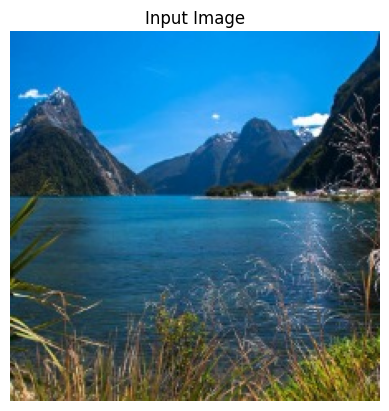

In [ ]:
print("DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)")
print("="*60)

# Example 1: A Real Photograph (expected: Likely Real)
print("\n--- Demo 1: Real Human Photo) ---")
real_human_photo_url = "/content/1000.jpg" # Example human face
result1 = zero_shot_image_detector(real_human_photo_url)

In [ ]:
import torch
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import os

# --- Load CLIP Model ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(model_name)

def zero_shot_image_detector(image_input, verbose=True):
    if verbose:
        print("\n--- Starting Zero-Shot Detection ---")

    image = None
    if isinstance(image_input, str):
        if image_input.startswith(('http://', 'https://')):
            try:
                image = Image.open(requests.get(image_input, stream=True, timeout=10).raw).convert("RGB")
            except Exception as e:
                print(f"Error loading image from URL: {e}")
                return None
        else:
            if not os.path.exists(image_input):
                print(f"Local file not found: {image_input}")
                return None
            try:
                image = Image.open(image_input).convert("RGB")
            except Exception as e:
                print(f"Error loading local image: {e}")
                return None
    elif isinstance(image_input, Image.Image):
        image = image_input.convert("RGB")
    else:
        print("Invalid image_input type.")
        return None

    if image is None:
        return {"prediction": "Error", "confidence": 0.0, "explanation": "Image loading failed."}

    # --- Prompts ---
    text_prompts = [
        # Origin detection
        "a real photograph",
        "an AI-generated image",
        "a deepfaked image",
        # Content category
        "a human face",
        "an animal",
        "an object",
        "a landscape"
    ]

    # --- Preprocess and Encode ---
    inputs = clip_processor(text=text_prompts, images=image, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        image_features = clip_model.get_image_features(pixel_values=inputs.pixel_values)
        text_features = clip_model.get_text_features(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask)

    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
    similarities = (image_features @ text_features.T).squeeze(0)
    similarities_percent = (similarities * 100).cpu().numpy()
    scores = dict(zip(text_prompts, similarities_percent))

    # --- Categorize Content ---
    categories = ["a human face", "an animal", "an object", "a landscape"]
    best_category = max(categories, key=lambda p: scores.get(p, 0))
    category_score = scores[best_category]

    # --- Determine Real / AI / Deepfake ---
    origins = {
        "Likely Real": "a real photograph",
        "Likely AI-generated": "an AI-generated image",
        "Likely Deepfake": "a deepfaked image"
    }
    best_origin_label = max(origins, key=lambda label: scores.get(origins[label], 0))
    best_origin_score = scores[origins[best_origin_label]]

    # Confidence = gap from next-best origin label
    other_origin_scores = [scores[origins[label]] for label in origins if label != best_origin_label]
    confidence = best_origin_score - max(other_origin_scores)

    # --- Output ---
    final_output = {
        "prediction": best_origin_label,
        "confidence": confidence,
        "top_matches": [
            (best_category, category_score),
            (best_origin_label, best_origin_score)
        ],
        "explanation": (
            f"The image is classified as '{best_category}', and it is {best_origin_label.lower()} "
            f"with a score of {best_origin_score:.2f}%."
        )
    }

    if verbose:
        print(f"\nPrediction: {final_output['prediction']}")
        print(f"Confidence Score: {final_output['confidence']:.2f}%")
        print("Top Matches:")
        for label, score in final_output["top_matches"]:
            print(f"- {label}: {score:.2f}%")
        print("Explanation:", final_output["explanation"])

        # Show the input image
        import matplotlib.pyplot as plt
        plt.imshow(image)
        plt.title("Input Image")
        plt.axis('off')
        plt.show()

    return final_output



DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)

--- Starting Zero-Shot Detection ---

Prediction: Likely Deepfake
Confidence Score: 0.72%
Top Matches:
- a human face: 25.23%
- Likely Deepfake: 23.84%
Explanation: The image is classified as 'a human face', and it is likely deepfake with a score of 23.84%.


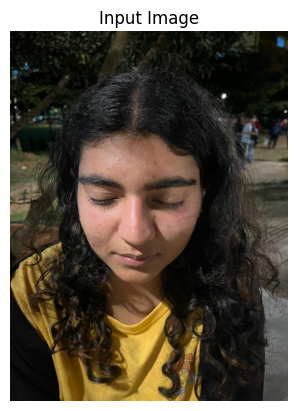

In [ ]:
print("DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)")

# Example 1: A Real Photograph (expected: Likely Real)
real_human_photo_url = "/content/788d6d1b-8efc-4062-9e82-0a19c2fd1d6f.jpg" # Example human face
result1 = zero_shot_image_detector(real_human_photo_url)

DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)

--- Starting Zero-Shot Detection ---

Prediction: Likely AI-generated
Confidence Score: 0.46%
Top Matches:
- a human face: 20.46%
- Likely AI-generated: 20.36%
Explanation: The image is classified as 'a human face', and it is likely ai-generated with a score of 20.36%.


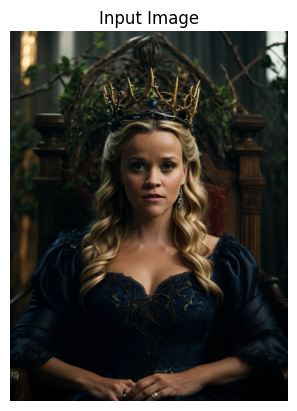

DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)

--- Starting Zero-Shot Detection ---

Prediction: Likely AI-generated
Confidence Score: 0.50%
Top Matches:
- a human face: 21.61%
- Likely AI-generated: 23.52%
Explanation: The image is classified as 'a human face', and it is likely ai-generated with a score of 23.52%.


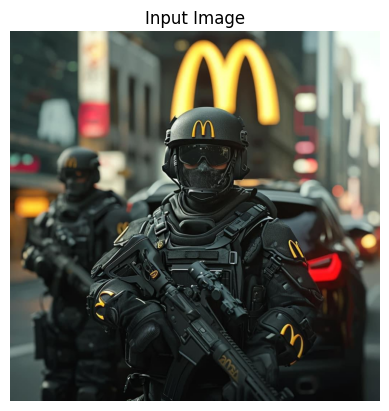

DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)

--- Starting Zero-Shot Detection ---

Prediction: Likely Real
Confidence Score: 1.78%
Top Matches:
- an object: 19.82%
- Likely Real: 22.57%
Explanation: The image is classified as 'an object', and it is likely real with a score of 22.57%.


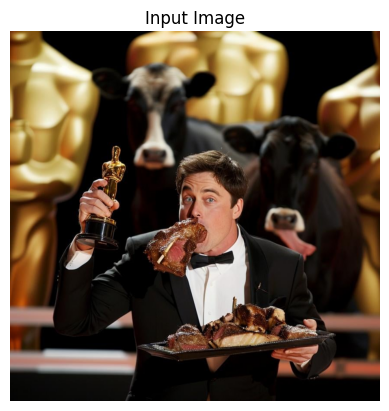

In [ ]:
print("DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)")

# Example 1: A Real Photograph (expected: Likely Real)
real_human_photo_url = "/content/10004.jpg" # Example human face
result1 = zero_shot_image_detector(real_human_photo_url)

print("DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)")

# Example 1: A Real Photograph (expected: Likely Real)
real_human_photo_url = "/content/10021.jpg" # Example human face
result1 = zero_shot_image_detector(real_human_photo_url)

print("DEMONSTRATION OF ZERO-SHOT IMAGE DEEPFAKE/AI-GEN DETECTION (A.1)")

# Example 1: A Real Photograph (expected: Likely Real)
real_human_photo_url = "/content/1001.jpg" # Example human face
result1 = zero_shot_image_detector(real_human_photo_url)

CLIP Prediction: Real (Confidence: Real=0.57, Deepfake=0.43)
Blur Score: 479.64
Noise Residual Mean: 3.19
Final Verdict: Real


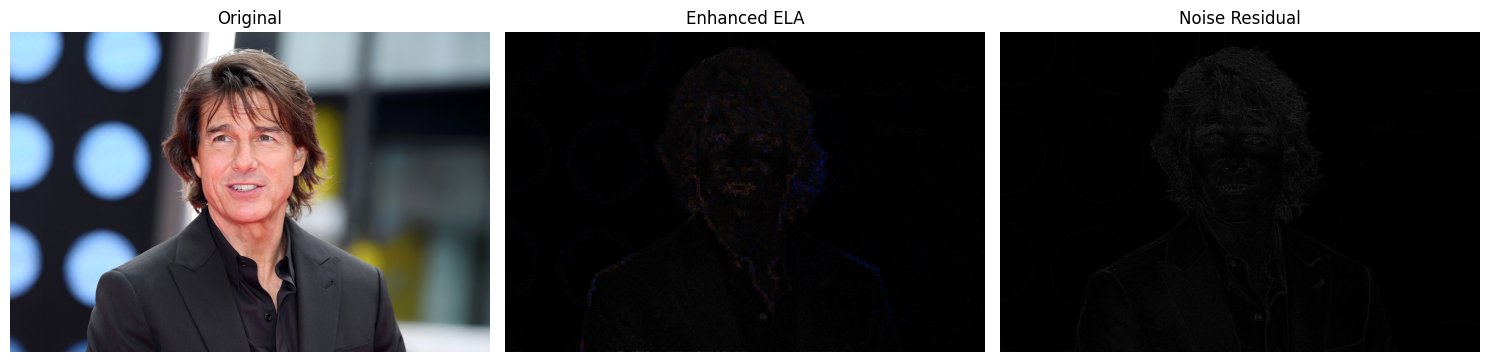

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
import matplotlib.pyplot as plt
import torch
from transformers import CLIPProcessor, CLIPModel

# Load CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def show_images(imgs, titles):
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        plt.subplot(1, len(imgs), i+1)
        if isinstance(img, np.ndarray):
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def enhanced_ela(original_path):
    original = Image.open(original_path).convert("RGB")
    temp_path = "/tmp/compressed.jpg"
    original.save(temp_path, "JPEG", quality=90)

    compressed = Image.open(temp_path)
    ela_image = ImageChops.difference(original, compressed)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

def blur_detector(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return lap_var

def noise_analysis(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)
    residual = cv2.absdiff(gray, denoised)
    return residual

def classify_clip(image_pil):
    inputs = processor(text=["This is a real face", "This is a deepfake"], images=image_pil, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1).detach().numpy()[0]
    return "Real" if probs[0] > probs[1] else "Deepfake", probs

def full_pipeline(image_path):
    # Load image
    image_cv = cv2.imread(image_path)
    image_pil = Image.open(image_path).convert("RGB")

    # ZSL classification
    zsl_pred, zsl_probs = classify_clip(image_pil)

    # ELA
    ela_img = enhanced_ela(image_path)

    # Noise Residuals
    residual_img = noise_analysis(image_cv)

    # Blur Detection
    blur_score = blur_detector(image_cv)

    # Final Decision Logic (heuristic)
    suspicious = (zsl_pred == "Deepfake") or blur_score < 100 or np.mean(residual_img) > 20

    final_result = "Deepfake" if suspicious else "Real"

    # Display results
    print(f"CLIP Prediction: {zsl_pred} (Confidence: Real={zsl_probs[0]:.2f}, Deepfake={zsl_probs[1]:.2f})")
    print(f"Blur Score: {blur_score:.2f}")
    print(f"Noise Residual Mean: {np.mean(residual_img):.2f}")
    print(f"Final Verdict: {final_result}")

    # Show all visuals
    show_images([image_cv, ela_img, residual_img],
                ["Original", "Enhanced ELA", "Noise Residual"])

# Example usage
full_pipeline("/content/licensed-image.jpg")


=== Deepfake Detection Report ===
CLIP Prediction       : Deepfake (Real=0.36, Deepfake=0.64)
Blur Score (sharpness): 22.34 (Low → more fake-like)
Noise Residual Mean   : 1.93 (High → more manipulation)
Final Verdict         : Deepfake


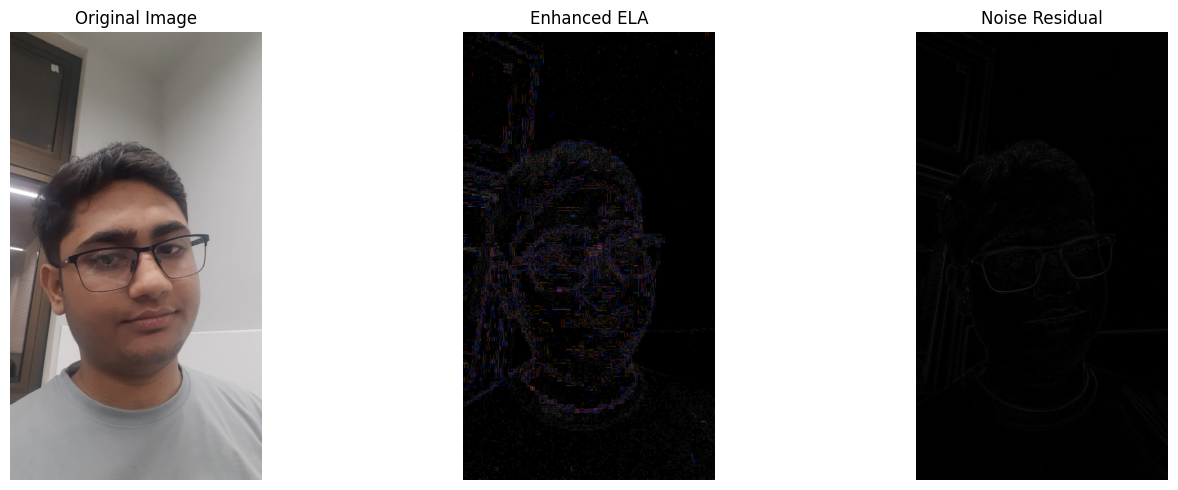

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
import matplotlib.pyplot as plt
import torch
from transformers import CLIPProcessor, CLIPModel

# Load CLIP model (Zero-Shot Learning model by OpenAI)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Function to display images side-by-side
def show_images(imgs, titles):
    plt.figure(figsize=(15, 5))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        plt.subplot(1, len(imgs), i+1)
        if isinstance(img, np.ndarray):
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Error Level Analysis (ELA) to highlight digital manipulations
def enhanced_ela(image_path):
    original = Image.open(image_path).convert("RGB")
    compressed_path = "/tmp/compressed.jpg"
    original.save(compressed_path, "JPEG", quality=90)
    compressed = Image.open(compressed_path)

    # Difference between original and compressed
    ela_img = ImageChops.difference(original, compressed)
    max_diff = max([ex[1] for ex in ela_img.getextrema()])
    scale = 255.0 / (max_diff if max_diff != 0 else 1)
    ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)
    return ela_img

# Detects blur using Laplacian variance — low value indicates blur (possible artifact)
def blur_detector(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Analyzes noise by subtracting a denoised version from the original
def noise_analysis(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    denoised = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)
    residual = cv2.absdiff(gray, denoised)
    return residual

# Classify image using CLIP with zero-shot text prompts
def classify_clip(image_pil):
    inputs = processor(text=["This is a real face", "This is a deepfake"], images=image_pil, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1).detach().numpy()[0]
    return "Real" if probs[0] > probs[1] else "Deepfake", probs

# Full Pipeline: load image, run all checks, and give decision
def full_pipeline(image_path):
    image_cv = cv2.imread(image_path)
    image_pil = Image.open(image_path).convert("RGB")

    # CLIP classification
    clip_label, clip_probs = classify_clip(image_pil)

    # ELA output
    ela_img = enhanced_ela(image_path)

    # Noise residual image
    residual_img = noise_analysis(image_cv)

    # Blur score
    blur_score = blur_detector(image_cv)

    # Heuristic rule for final verdict
    suspicious = (
        clip_label == "Deepfake" or
        blur_score < 100 or
        np.mean(residual_img) > 20
    )
    final_result = "Deepfake" if suspicious else "Real"

    # Print detailed explanation
    print("=== Deepfake Detection Report ===")
    print(f"CLIP Prediction       : {clip_label} (Real={clip_probs[0]:.2f}, Deepfake={clip_probs[1]:.2f})")
    print(f"Blur Score (sharpness): {blur_score:.2f} (Low → more fake-like)")
    print(f"Noise Residual Mean   : {np.mean(residual_img):.2f} (High → more manipulation)")
    print(f"Final Verdict         : {final_result}")
    print("=================================")

    # Display all key visuals
    show_images([image_cv, ela_img, residual_img],
                ["Original Image", "Enhanced ELA", "Noise Residual"])

# Example usage — Replace with your image path
full_pipeline("/content/new.jpg")


CLIP Prediction       : Deepfake (0.79), Real (0.21)
Blur Score (sharpness): 1859.04
ELA Noise Mean        : 0.95
Final Verdict         : Uncertain
Explanation:
  → CLIP confidence for deepfake is high (0.79)


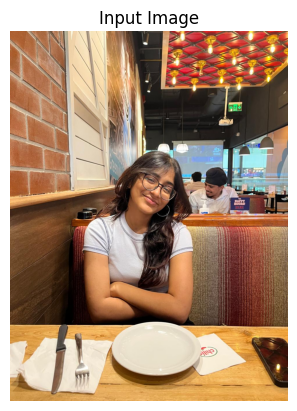

In [ ]:
import torch
from PIL import Image
import numpy as np
import cv2
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

# Load CLIP model
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Predict using CLIP
def get_clip_prediction(image):
    inputs = processor(text=["a photo of a real person", "a photo of a deepfake person"], images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1).squeeze().tolist()
    return {"Real": probs[0], "Deepfake": probs[1]}

# Compute image blur using Laplacian variance
def compute_blur_score(image_np):
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    score = cv2.Laplacian(gray, cv2.CV_64F).var()
    return score

# Error Level Analysis (ELA)
def compute_ela_mean(image_path):
    image = Image.open(image_path).convert('RGB')
    resaved_path = "temp_ela.jpg"
    image.save(resaved_path, 'JPEG', quality=90)

    resaved = Image.open(resaved_path).convert('RGB')
    ela_image = ImageChops.difference(image, resaved)
    ela_np = np.array(ela_image)
    return ela_np.mean()

# Decision based on combined signals
def get_final_verdict(clip_probs, blur_score, ela_score):
    clip_real = clip_probs["Real"]
    clip_fake = clip_probs["Deepfake"]

    decision = ""
    explanation = []

    if clip_fake > 0.7:
        explanation.append(f"CLIP confidence for deepfake is high ({clip_fake:.2f})")
    if blur_score < 100:
        explanation.append(f"Image is very blurry (Blur Score = {blur_score:.2f})")
    elif blur_score < 250:
        explanation.append(f"Image is moderately blurry (Blur Score = {blur_score:.2f})")

    if ela_score > 5:
        explanation.append(f"ELA noise is high ({ela_score:.2f}) indicating manipulation")
    elif ela_score > 3:
        explanation.append(f"ELA noise is moderate ({ela_score:.2f})")

    # Decision logic
    if clip_fake > 0.7 and (blur_score < 100 or ela_score > 5):
        decision = "Deepfake"
    elif clip_real > 0.5 and blur_score > 250 and ela_score < 3:
        decision = "Real"
    else:
        decision = "Uncertain"

    return decision, explanation

# Full pipeline
def analyze_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    clip_probs = get_clip_prediction(image)
    blur_score = compute_blur_score(image_np)
    ela_score = compute_ela_mean(image_path)
    verdict, explanation = get_final_verdict(clip_probs, blur_score, ela_score)

    print("CLIP Prediction       :", f"Deepfake ({clip_probs['Deepfake']:.2f}), Real ({clip_probs['Real']:.2f})")
    print("Blur Score (sharpness):", f"{blur_score:.2f}")
    print("ELA Noise Mean        :", f"{ela_score:.2f}")
    print("Final Verdict         :", verdict)
    print("Explanation:")
    for line in explanation:
        print("  →", line)

    # Show image
    plt.imshow(image_np)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

# Example usage
analyze_image("/content/pls.jpg")  # Replace with actual image path


In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
import cv2
import os

# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model.to(device)

# Categories
categories = [
    "a photo of a human",
    "a photo of an animal",
    "a photo of a landscape",
    "a photo of an object",
    "a painting or artwork",
    "an AI-generated image"
]

# ELA
def get_ela_image(image: Image.Image, quality: int = 90) -> Image.Image:
    path = "temp_ela.jpg"
    image.save(path, "JPEG", quality=quality)
    compressed = Image.open(path)
    ela = ImageChops.difference(image, compressed)
    ela = ImageEnhance.Brightness(ela).enhance(10)
    os.remove(path)
    return ela

# Blur
def calculate_blur(img_np):
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Noise
def calculate_noise(img_np):
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    return np.mean(np.abs(gray - blur))

# Predict type (category)
def classify_category(image: Image.Image):
    inputs = clip_processor(text=categories, images=image, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1).detach().cpu().numpy()[0]
    top_idx = np.argmax(probs)
    return categories[top_idx], probs[top_idx]

# Predict real vs deepfake
def predict_real_vs_fake(image: Image.Image):
    inputs = clip_processor(text=["a photo of a real face", "a photo of a deepfake face"],
                            images=image, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)
    probs = outputs.logits_per_image.softmax(dim=1).detach().cpu().numpy()[0]
    return {"Real": probs[0], "Deepfake": probs[1]}

# Main pipeline
def analyze_image(img_path):
    image = Image.open(img_path).convert("RGB")
    img_np = np.array(image)

    # CLIP predictions
    category, cat_conf = classify_category(image)
    real_fake_probs = predict_real_vs_fake(image)

    blur_score = calculate_blur(img_np)
    noise_score = calculate_noise(img_np)
    ela_img = get_ela_image(image)
    ela_score = np.mean(np.array(ela_img)) / 255.0

    # Decision logic
    clip_real = real_fake_probs["Real"]
    clip_fake = real_fake_probs["Deepfake"]

    reasons = []
    if clip_fake > 0.7:
        verdict = "Deepfake"
        reasons.append("CLIP is confident it's a deepfake (>0.7)")
    elif clip_real > 0.7:
        verdict = "Real"
        reasons.append("CLIP is confident it's real (>0.7)")
    elif blur_score < 100 and noise_score > 3.5 and ela_score > 0.08:
        verdict = "Deepfake"
        reasons.append("Blur is low, noise is high, and ELA suggests manipulation")
    elif blur_score < 100 and noise_score < 2.0:
        verdict = "Real"
        reasons.append("Blurry but not noisy or manipulated — likely a real low-quality image")
    else:
        verdict = "Uncertain"
        reasons.append("CLIP is uncertain and forensics are mixed")

    # Report
    print("\n--- Image Analysis ---")
    print(f"Category Prediction   : {category} ({cat_conf:.2f})")
    print(f"CLIP Real/Fake Scores : Real={clip_real:.2f}, Deepfake={clip_fake:.2f}")
    print(f"Blur Score (sharpness): {blur_score:.2f} (↑ sharp)")
    print(f"Noise Residual Mean   : {noise_score:.2f} (↑ manipulation)")
    print(f"ELA Brightness Score  : {ela_score:.3f} (↑ compression artifacts)")
    print(f"Final Verdict         : {verdict}")
    print("Why?:")
    for r in reasons:
        print(f"- {r}")

# Test example
analyze_image("/content/licensed-image.jpg")



--- Image Analysis ---
Category Prediction   : a photo of a human (0.91)
CLIP Real/Fake Scores : Real=0.23, Deepfake=0.77
Blur Score (sharpness): 479.64 (↑ sharp)
Noise Residual Mean   : 55.56 (↑ manipulation)
ELA Brightness Score  : 0.012 (↑ compression artifacts)
Final Verdict         : Deepfake
Why?:
- CLIP is confident it's a deepfake (>0.7)


In [ ]:
import os
import torch
from transformers import CLIPProcessor, CLIPModel

# Make sure clip_model and clip_processor are already loaded in your session
# (from the initial part of your code: CLIPModel.from_pretrained and CLIPProcessor.from_pretrained)

# Define directory to save CLIP model
CLIP_MODELS_DIR = '/content/clip_model_saved/'
os.makedirs(CLIP_MODELS_DIR, exist_ok=True)

print(f"Saving CLIP model and processor to {CLIP_MODELS_DIR}...")
clip_model.save_pretrained(CLIP_MODELS_DIR)
clip_processor.save_pretrained(CLIP_MODELS_DIR)
print("CLIP model and processor saved successfully.")

# --- Optional: Zip the saved model for easier download ---
print("\nZipping CLIP model for download...")
# This creates a zip file of the saved CLIP model folder
!zip -r /content/clip_model_saved.zip {CLIP_MODELS_DIR}

from google.colab import files
print("Downloading clip_model_saved.zip... (Check your browser's download location)")
# This initiates the download of the zip file to your local computer
files.download('/content/clip_model_saved.zip')

Saving CLIP model and processor to /content/clip_model_saved/...


NameError: name 'clip_model' is not defined